In [2]:
from ssh_pymongo import MongoSession
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import pandas as pd
import os

# Initialize MongoDB instance
client = MongoSession(
            str(os.getenv("REMOTE_SERVER")),
            port=22,
            user=str(os.getenv("SSH_USER")),
            password=str(os.getenv("SSH_AUTHENTICATION")),
            uri=str(os.getenv("MONGOSTRING")))
        
database = client.connection["traffic_analysis"]
collection = database['vehicle']

# Retrieve all documents
all_documents = collection.find()  # Empty query to fetch all

# Count vehicles per timestamp
vehicle_counts = defaultdict(int)

In [ ]:
pipeline = [
    # {
    #     '$match': {
    #         'dmy': '*_10_24',
    #         # 'confidence' : {"$gte", 0.70}
    #     }},
        {'$group': {
            '_id': {
                # "class_id" : "$class_id",
                "class_name" : "$class_name",
                # "confidence": "$confidence",
                'time': { '$substr': ['$time_stamp', 0, 14] },
            },
            # "confidence": "$confidence",
            'count': {"$sum" : 1}
        }
    },
    {"$sort": {"_id.dmy":1}}
]

results = list(collection.aggregate(pipeline))

class_name    object
time          object
count          int64
dtype: object
0       10_10_24_16_40
1       10_10_24_07_31
2       09_10_24_10_20
3       13_10_24_10_22
4       09_10_24_11_54
             ...      
2368    13_10_24_13_20
2369    13_10_24_11_14
2370    10_10_24_08_00
2371    13_10_24_11_12
2372    13_10_24_12_16
Name: time, Length: 2373, dtype: object
class_name      bicycle  bird  bus    car  dog  person  truck
time                                                         
07_10_24_17_38      NaN   NaN  NaN    7.0  NaN    22.0    NaN
07_10_24_17_39      2.0   NaN  NaN   17.0  NaN     2.0    NaN
07_10_24_17_41      NaN   NaN  2.0   69.0  NaN     7.0    NaN
07_10_24_17_42      NaN   NaN  NaN  139.0  NaN     NaN    NaN
07_10_24_17_43      1.0   NaN  NaN  139.0  NaN     NaN    NaN
class_name
bicycle    float64
bird       float64
bus        float64
car        float64
dog        float64
person     float64
truck      float64
dtype: object


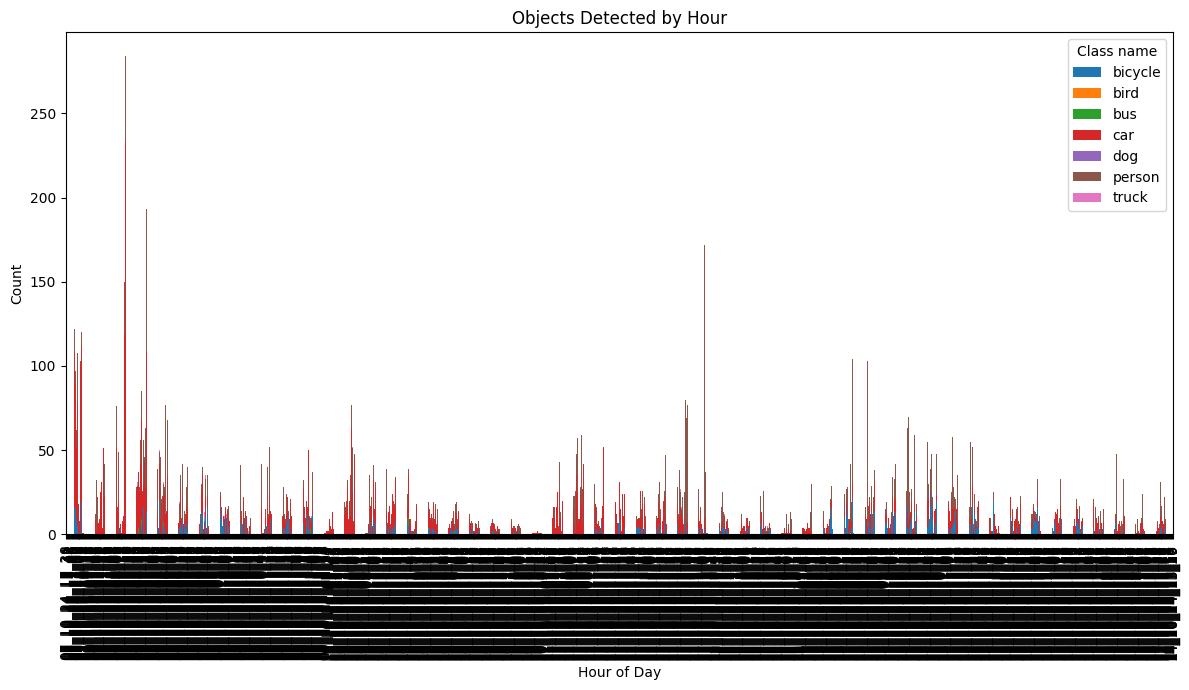

In [23]:
if not results:
    print("No data found with the given criteria.")
else:
    # Process aggregation results into a DataFrame
    data = {
        'class_name': [], 
        'time': [], 
        'count': []
    }
    
    for result in results:
        data['class_name'].append(result['_id']['class_name'])
        data['time'].append(result['_id']['time'].split('_')[-2])
        data['count'].append(result['count'])
    
    df = pd.DataFrame(data)
    
    # Verify data types
    print(df.dtypes)
    print(df['time'])
    
    # Ensure 'class_id' and 'count' are numeric
    # df['class_name'] = pd.to_numeric(df['class_name'], errors='coerce')
    df['count'] = pd.to_numeric(df['count'], errors='coerce')
    
    # Check for NaNs after conversion
    if df[['count']].isnull().any().any():
        print("Warning: NaN values found after conversion. Check your data.")
    
    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(values='count', index='time', columns='class_name', aggfunc='sum')
    
    # Display pivot_df
    print(pivot_df.head())
    print(pivot_df.dtypes)
    
    # Ensure pivot_df contains numeric data
    if pivot_df.empty:
        print("Pivot DataFrame is empty. No data to plot.")
    else:
        # Plotting
        pivot_df.plot(kind='bar', stacked=True, figsize=(12, 7))
        plt.title('Objects Detected by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Count')
        plt.legend(title='Class name')
        plt.tight_layout()
        plt.show()